In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
tf.random.set_seed(0)

# Check the heuristics to select nosie variance

In [55]:
from src.ksd.kernel import median_heuristic, l2norm
from experiments.compare_samplers import create_mixture_gaussian

In [56]:
med_ls = []
delta_ls = np.linspace(1., 10, 100)
dim = 5
for delta in tqdm(delta_ls):
    target = create_mixture_gaussian(dim=dim, delta=delta)
    samples = target.sample(500)
    l2norm_mat = l2norm(samples, tf.identity(samples))
    med_ls.append(median_heuristic(l2norm_mat) / dim)
    

  0%|          | 0/100 [00:00<?, ?it/s]

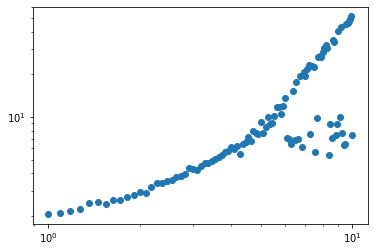

In [57]:
plt.scatter(delta_ls, med_ls)
plt.xscale("log")
plt.yscale("log")

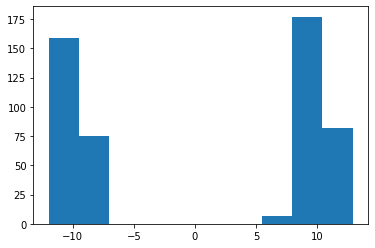

In [49]:
_ = plt.hist(samples[:, 0].numpy())

In [126]:
# target = tfd.MultivariateNormalDiag([0.])
# proposal = tfd.MultivariateNormalDiag([0.5])
from experiments.compare_samplers import create_mixture_gaussian
dim = 1
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta)
proposal_mean = - delta * tf.eye(dim)[:, 0]
proposal = tfd.MultivariateNormalDiag(proposal_mean)

# kernel = RBF(sigma_sq=1e5)
kernel = IMQ(med_heuristic=True)

(array([  3.,  16.,  68., 166., 217., 248., 149.,  91.,  30.,  12.]),
 array([-7.3585253 , -6.710873  , -6.0632205 , -5.4155684 , -4.767916  ,
        -4.120264  , -3.4726114 , -2.8249593 , -2.177307  , -1.5296546 ,
        -0.88200235], dtype=float32),
 <BarContainer object of 10 artists>)

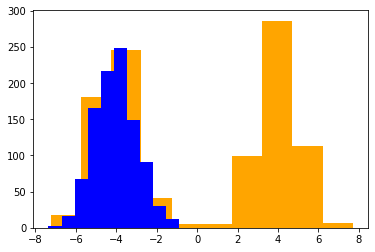

In [127]:
plt.hist(target.sample(1000).numpy(), color="orange")
plt.hist(proposal.sample(1000).numpy(), color="blue")

In [128]:
ksd = KSD(target=target, kernel=kernel)

In [129]:
from src.ksd.bootstrap import Bootstrap

bootstrap = Bootstrap(ksd)
n = 100
proposal_sample = proposal.sample(n)

In [130]:
ksd(proposal_sample, proposal_sample)

<tf.Tensor: shape=(), dtype=float32, numpy=0.011349878>

In [131]:
alpha = 0.05
res  = bootstrap.test_once(alpha=alpha, num_boost=200, X=proposal_sample)

In [132]:
# np.diagonal(res[0, :, :].numpy())
# plt.hist(res[0, :, :].numpy().reshape((-1,)))

In [133]:
print(bootstrap.test_summary)

Significance	: 0.05 
Critical value	: 0.02296 
Test statistic	: -0.01065 
Test result	: NOT rejected


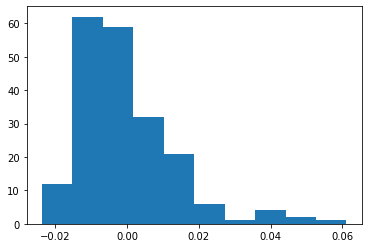

In [134]:
ksd_star = bootstrap.ksd_star.numpy()
_ = plt.hist(ksd_star)

In [135]:
res = bootstrap.test(alpha=alpha, num_test=100, num_boost=200, X=proposal_sample)

Repeating tests: 100 of 100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


In [136]:
reject = res[1]
print("num rejected:", np.sum(reject), "out of", len(reject))

num rejected: 0 out of 100


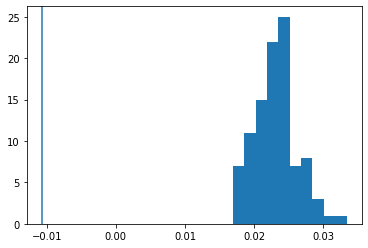

In [137]:
plt.hist(res[2])
plt.axvline(x=bootstrap.ksd_hat)

In [57]:
target = tfd.MultivariateNormalDiag([0.])
proposal = tfd.MultivariateNormalDiag([2.])

kernel = RBF()
# kernel = IMQ()

In [26]:
import gpflow

X = tf.constant([[1., 2, 3], [4, 5, 6]], dtype=tf.float64)
Y = tf.identity(X)

In [72]:
## autodiff
kernel = gpflow.kernels.SquaredExponential(lengthscales=1/tf.math.sqrt(2.))
# kernel, grad and hessian
with tf.GradientTape() as g:
    g.watch(X)
    with tf.GradientTape() as tapeY, tf.GradientTape() as tapeX:
        tapeY.watch(Y)
        tapeX.watch(X)

        K_XY = kernel(X, Y) # n x m
        K_XY_Y = tf.reduce_sum(K_XY, axis=1)
        K_XY_X = tf.reduce_sum(K_XY, axis=0)

    # grad_k_Y
    grad_K_Y = tapeY.jacobian(K_XY_Y, Y) # n x m x dim
    grad_K_Y_sum = tf.reduce_sum(grad_K_Y, axis=0)

    # grad_k_X (assuming radial kernel)
    # TODO: figure out why this is not automatically correct
    grad_K_X = - grad_K_Y

gradgrad_K = g.jacobian(grad_K_Y_sum, X) # n x dim x m x dim
gradgrad_K = tf.transpose(gradgrad_K, (0, 2, 1, 3)) # n x m x dim x dim

In [61]:
## explicit
# kernel
kernel2 = RBF()
kernel2.sigma = tf.constant(1., dtype=tf.float64)
K_XY2 = kernel2(X, Y) # n x m

# kernel grad
grad_K_Y2 = kernel2.grad_second(X, Y) # n x m x dim
grad_K_X2 = kernel2.grad_first(X, Y) # n x m x dim

gradgrad_K2 = kernel2.gradgrad(X, Y) # n x m x dim x dim

In [73]:
K_XY = kernel(X, Y)
tf.experimental.numpy.allclose(K_XY, K_XY2)
K_XY, K_XY2

(<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1.00000000e+00, 1.87952708e-12],
        [1.87952708e-12, 1.00000000e+00]])>,
 <tf.Tensor: shape=(2, 2), dtype=float64, numpy=
 array([[1.00000000e+00, 1.87952887e-12],
        [1.87952887e-12, 1.00000000e+00]])>)

In [59]:
print(tf.experimental.numpy.allclose(grad_K_Y, grad_K_Y2))
print(tf.experimental.numpy.allclose(grad_K_X, grad_K_X2))
# grad_K_Y, grad_K_Y2

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)


In [60]:
tf.experimental.numpy.allclose(gradgrad_K, gradgrad_K2)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [76]:
proposal_sample = proposal.sample(100)

In [54]:
_ = plt.hist(proposal_sample.numpy())

NameError: name 'proposal_sample' is not defined

In [91]:
# delete
target = tfd.MultivariateNormalDiag([0.])
proposal = tfd.MultivariateNormalDiag([2.])
proposal_sample = proposal.sample(100)

kernel = RBF()

In [92]:
ksd = KSD(target=target, kernel=kernel)
ksd_val = ksd(proposal_sample, tf.identity(proposal_sample)).numpy()
ksd_val

1.0535643

In [99]:

kernel_auto(proposal_sample, proposal_sample)

<tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[1.00000000e+00, 3.49921808e-02, 1.30525295e-05, ...,
        1.39709402e-04, 9.41249132e-02, 1.06716514e-01],
       [3.49921808e-02, 1.00000000e+00, 9.84499678e-02, ...,
        2.67552495e-01, 9.17319119e-01, 1.56024180e-05],
       [1.30525295e-05, 9.84499678e-02, 1.00000000e+00, ...,
        8.69249344e-01, 3.69171910e-02, 6.11884154e-11],
       ...,
       [1.39709402e-04, 2.67552495e-01, 8.69249344e-01, ...,
        1.00000000e+00, 1.25008643e-01, 2.00707295e-09],
       [9.41249132e-02, 9.17319119e-01, 3.69171910e-02, ...,
        1.25008643e-01, 1.00000000e+00, 1.01068239e-04],
       [1.06716514e-01, 1.56024180e-05, 6.11884154e-11, ...,
        2.00707295e-09, 1.01068239e-04, 1.00000000e+00]], dtype=float32)>

In [105]:
from src.ksd.ksd import KSDAuto

kernel_auto = gpflow.kernels.SquaredExponential(lengthscales=1.)
kernel_auto.variance = tf.constant(1., dtype=tf.float32)
ksd_auto = KSDAuto(target=target, kernel=kernel_auto)
ksd_val = ksd_auto(proposal_sample, tf.identity(proposal_sample)).numpy()
ksd_val

1.0535648

In [73]:
def run_ksd_experiment(nrep, target, proposal, kernel):
    """compute KSD and repeat for nrep times"""
    ksd = KSD(target=target, kernel=kernel)
    
    nsamples_list = list(range(10, 100, 10)) + list(range(100, 1100, 100))
    ksd_list = []
    ksd_df = pd.DataFrame(columns=["n", "ksd", "seed"])
    for n in nsamples_list:
        print(f"n = {n}")
        ksd_n_list = []
        for seed in range(nrep):
            proposal_sample = proposal.sample(n)
            ksd_val = ksd(proposal_sample, tf.identity(proposal_sample)).numpy()
            ksd_n_list.append(ksd_val)
            ksd_df.loc[len(ksd_df)] = [n, ksd_val, seed]
    return ksd_df

In [60]:
nrep = 10

ksd_df = run_ksd_experiment(nrep, target, proposal, kernel)

n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 200
n = 300
n = 400
n = 500
n = 600
n = 700
n = 800
n = 900
n = 1000


(0.0, 3.682068687856197)

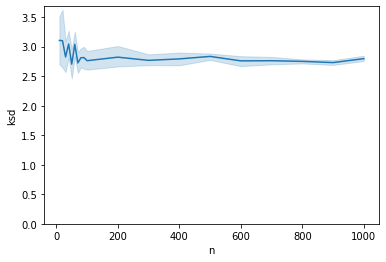

In [61]:
sns.lineplot(data=ksd_df, x="n", y="ksd")
plt.ylim((0, None))

# Mixture of gaussian experiment

In [84]:
def create_mixture_gaussian(dim, delta):
    e1 = tf.eye(dim)[:, 0]
    mix_gauss = tfd.Mixture(
      cat=tfd.Categorical(probs=[0.5, 0.5]),
      components=[
        tfd.MultivariateNormalDiag(-delta * e1),
        tfd.MultivariateNormalDiag(delta * e1)
    ])
    return mix_gauss
    

In [85]:
delta = 3
dim = 5

target = create_mixture_gaussian(dim=dim, delta=delta)

proposal_mean = - delta * tf.eye(dim)[:, 0]
proposal = tfd.MultivariateNormalDiag(proposal_mean)

(array([ 27., 148., 223.,  96.,  17.,  19.,  82., 206., 146.,  36.]),
 array([-5.7075515 , -4.5770664 , -3.446581  , -2.3160958 , -1.1856105 ,
        -0.05512524,  1.0753601 ,  2.2058454 ,  3.3363304 ,  4.466816  ,
         5.597301  ], dtype=float32),
 <BarContainer object of 10 artists>)

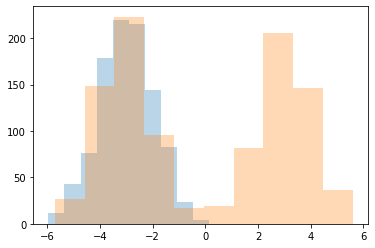

In [86]:
plt.hist(proposal.sample(1000).numpy()[:, 0], alpha=0.3)
plt.hist(target.sample(1000).numpy()[:, 0], alpha=0.3)

In [87]:
ksd_df = run_ksd_experiment(nrep, target, proposal, kernel)

n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 200
n = 300
n = 400
n = 500
n = 600
n = 700
n = 800
n = 900
n = 1000


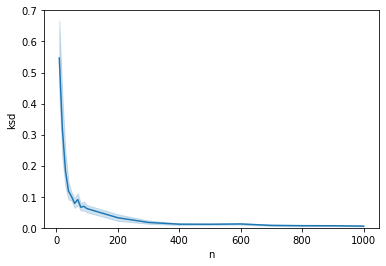

In [88]:
sns.lineplot(data=ksd_df, x="n", y="ksd")
_ = plt.ylim((0, None))

n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 200
n = 300
n = 400
n = 500
n = 600
n = 700
n = 800
n = 900
n = 1000


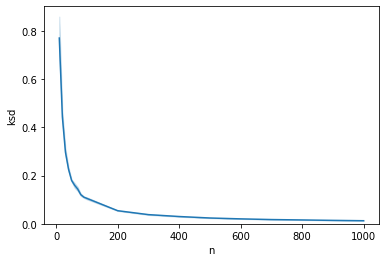

In [90]:
# with RBF
ksd_df = run_ksd_experiment(nrep, target, proposal, RBF())

sns.lineplot(data=ksd_df, x="n", y="ksd")
_ = plt.ylim((0, None))
# plt.xscale("log")

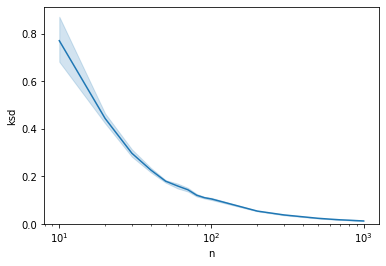

In [92]:
sns.lineplot(data=ksd_df, x="n", y="ksd")
_ = plt.ylim((0, None))
plt.xscale("log")